<a href="https://colab.research.google.com/github/Aaron-Darcy/Computational-Maths-Project/blob/main/Comp_Maths_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease Prediction Using a Neural Network From Scratch  
### MSc in Data Science — Computational Mathematics Mini-Project

This notebook implements a complete neural network, using only NumPy.  
No machine learning libraries (TensorFlow, PyTorch, Scikit-Learn, SciPy) are used.

The goal is to classify whether a patient has heart disease using 11 clinical features.


## Project Overview
This project demonstrates the full workflow of building and training a neural network exactly as described in:

- **Lecture 8 — Backpropagation**  
- **Lecture 9 — Gradient Descent**  
- **Lecture 10 — Neural Networks**

### What this project includes:
- Manual preprocessing (categorical → numerical → normalised)
- Construction of feature matrix **X** and label vector **y**
- Implementation of:
  - Forward propagation  
  - Backpropagation (chain rule)  
  - Gradient descent updates  
  - Sigmoid activation  
  - Binary cross-entropy loss  
- Support for a **variable number of layers and neurons**
- Demonstration of the training process and improved predictions after further training

### Network Architecture Used
Input → 16 neurons → 8 neurons → 1 output neuron (sigmoid)


##Load Data

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Load heart.csv
data = []
with open('/content/drive/MyDrive/ColabNotebooks/Projects/MathsProject/heart.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        data.append(row)

print("Loaded:", len(data), "rows")




Loaded: 918 rows


## Preprocessing the Dataset

The neural network requires fully numerical input.  
We prepare the dataset by:

1. Converting binary categorical attributes to 0/1  
2. Applying manual one-hot encoding  
3. Building numerical feature matrix **X**  
4. Normalising continuous variables  
5. Splitting into 80 percent training and 20 percent testing data  

All preprocessing is implemented manually using Python and NumPy.


In [42]:
# Binary categorical mappings
cat_maps = {
    "Sex": {"M":0, "F":1},
    "ExerciseAngina": {"N":0, "Y":1},
}

# One-hot encoded columns
onehot_columns = ["ChestPainType", "RestingECG", "ST_Slope"]

# Find unique categories for each one-hot column
unique_vals = {col:set() for col in onehot_columns}
for row in data:
    for col in onehot_columns:
        unique_vals[col].add(row[col])

unique_vals = {col:sorted(list(vals)) for col, vals in unique_vals.items()}

def one_hot(value, categories):
    vec = np.zeros(len(categories))
    vec[categories.index(value)] = 1
    return vec


## Building the Feature Matrix (X) and Label Vector (y)

We convert each row of the dataset into:

- **X**: numerical feature vector  
- **y**: target label (0 = no heart disease, 1 = heart disease)

This includes:
- Continuous numerical values  
- Binary encoded categories  
- One-hot encoded attributes  


In [43]:
X = []
y = []

numeric_cols = ["Age", "RestingBP", "Cholesterol", "FastingBS",
                "MaxHR", "Oldpeak"]

for row in data:
    features = []

    # Add numeric features
    for col in numeric_cols:
        features.append(float(row[col]))

    # Add binary categorical
    for col in cat_maps:
        features.append(cat_maps[col][row[col]])

    # Add one-hot encoded
    for col in onehot_columns:
        features.extend(one_hot(row[col], unique_vals[col]))

    X.append(features)
    y.append(int(row["HeartDisease"]))

X = np.array(X, dtype=float)
y = np.array(y).reshape(-1,1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (918, 18)
Shape of y: (918, 1)


## Normalising Numerical Features

To help the neural network converge, all continuous numerical columns are standardised:

Only the true numerical features are normalised (not the one-hot vectors).


In [44]:
for i in range(len(numeric_cols)):
    col = X[:, i]
    X[:, i] = (col - col.mean()) / (col.std() + 1e-9)


## Splitting the Dataset

We split the dataset manually:

- 80 percent for training  
- 20 percent for testing  

A random permutation ensures the data is shuffled


In [45]:
np.random.seed(42)
idx = np.random.permutation(len(X))

train_size = int(0.8 * len(X))
train_idx = idx[:train_size]
test_idx  = idx[train_size:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx], y[test_idx]

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))


Training samples: 734
Test samples: 184


## Train/Validation Split (Early Stopping)

To reduce overfitting, we split the original training data into:

- **Training set**: used to update weights via gradient descent  
- **Validation set**: used only to *monitor generalisation* during training  

The validation set is not used for weight updates. It is used to decide when to stop training
early if the model stops improving on unseen data.


In [46]:
# Split training data into Train + Validation sets (prevents overfitting)

np.random.seed(123)
idx2 = np.random.permutation(len(X_train))

val_n = int(0.15 * len(X_train))

val_idx = idx2[:val_n]
tr_idx  = idx2[val_n:]

X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
X_val, y_val = X_train[val_idx], y_train[val_idx]

print("Train:", len(X_tr))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 624
Validation: 110
Test: 184


## Activation & Loss Functions

### Sigmoid Activation
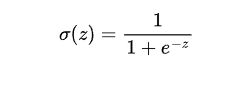

### Binary Cross-Entropy Loss
Used because the problem is binary classification

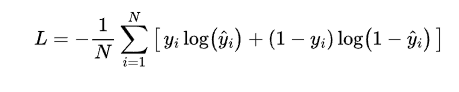



In [47]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(a):
    return a * (1 - a)

def binary_cross_entropy(y, y_hat):
    eps = 1e-9
    return -np.mean(y*np.log(y_hat+eps) + (1-y)*np.log(1-y_hat+eps))


## Neural Network Class

The class below implements:

- Weight initialisation  
- Forward propagation  
- Backpropagation  
- Gradient descent updates  
- Training loop  
- Prediction function  

This network works entirely through matrix multiplication using NumPy.


In [48]:
class NeuralNet:
    def __init__(self, layer_sizes, lr=0.01):
        # Learning rate for gradient descent
        self.lr = lr

        # Number of layers (input → hidden layers → output)
        self.L = len(layer_sizes) - 1

        # Weight and bias storage
        self.W = []
        self.b = []

        # Initialise weights and biases for each layer
        for i in range(self.L):
            # Random weights
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2/layer_sizes[i])

            # Biases start at zero
            b = np.zeros((1, layer_sizes[i+1]))

            self.W.append(w)
            self.b.append(b)

    def forward(self, X):
        # Store activations (layer outputs)
        a = X
        activations = [a]

        # Store linear combinations z = Wx + b
        zs = []

        # Forward pass through all layers
        for i in range(self.L):
            z = a @ self.W[i] + self.b[i]   # Linear step
            a = sigmoid(z)                  # Apply activation function
            zs.append(z)
            activations.append(a)

        return zs, activations

    def backward(self, zs, activations, y):
        # Gradient storage
        grads_W = []
        grads_b = []

        # Output layer activation
        aL = activations[-1]

        # Derivative of loss w.r.t final activation
        dL_da = -(y/aL) + ((1-y)/(1-aL))

        # Derivative of activation w.r.t z
        da_dz = sigmoid_deriv(aL)

        # Combine to get dL/dz for the output layer
        dL_dz = dL_da * da_dz

        # Gradient for last layer weights and biases
        grads_W.append(activations[-2].T @ dL_dz / len(y))
        grads_b.append(np.mean(dL_dz, axis=0, keepdims=True))

        # Backpropagate through hidden layers
        d = dL_dz
        for i in range(self.L-2, -1, -1):
            # Pass error backwards
            da = d @ self.W[i+1].T

            # Convert derivative w.r.t activation to derivative w.r.t z
            dz = da * sigmoid_deriv(activations[i+1])

            # Weight and bias gradients for this layer
            grads_W.append(activations[i].T @ dz / len(y))
            grads_b.append(np.mean(dz, axis=0, keepdims=True))

            # Move to previous layer
            d = dz

        # Reverse because we built gradient lists backwards
        grads_W.reverse()
        grads_b.reverse()

        return grads_W, grads_b

    def update(self, grads_W, grads_b):
        # Gradient descent update step for each layer
        for i in range(self.L):
            self.W[i] -= self.lr * grads_W[i]
            self.b[i] -= self.lr * grads_b[i]

    def train(self, X, y, epochs=5000, X_val=None, y_val=None, patience=20, min_delta=1e-4):
        losses = []
        val_losses = []

        best_val = float("inf")
        best_state = None
        no_improve = 0

        for epoch in range(epochs):
            zs, activations = self.forward(X)
            y_hat = activations[-1]

            loss = binary_cross_entropy(y, y_hat)
            losses.append(loss)

            grads_W, grads_b = self.backward(zs, activations, y)
            self.update(grads_W, grads_b)

            # Validation + Early Stopping
            if X_val is not None and y_val is not None:
                _, val_acts = self.forward(X_val)
                val_hat = val_acts[-1]
                vloss = binary_cross_entropy(y_val, val_hat)
                val_losses.append(vloss)

                if vloss < best_val - min_delta:
                    best_val = vloss
                    best_state = ([w.copy() for w in self.W], [b.copy() for b in self.b])
                    no_improve = 0
                else:
                    no_improve += 1

                    if no_improve >= patience:
                        # Restore best weights (prevents overfitting)
                        self.W = [w.copy() for w in best_state[0]]
                        self.b = [b.copy() for b in best_state[1]]

                        print(f"Early stopping at epoch {epoch}. Best val loss = {best_val:.4f}")
                        break

            if epoch % 50 == 0:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch}, Train Loss={loss:.4f}, Val Loss={vloss:.4f}")
                else:
                    print(f"Epoch {epoch}, Loss={loss:.4f}")

        return losses, val_losses

    def predict(self, X):
        # Forward pass and classify based on sigmoid output
        _, activations = self.forward(X)
        return (activations[-1] > 0.5).astype(int)


## Training the Neural Network

We train using:

- Learning rate = 0.05  
- Epochs = 5000  
- Architecture = [input_dim, 16, 8, 1]

Training for too many epochs can cause **overfitting**: the training loss continues to decrease but performance on unseen data may stop improving.The loss should steadily decrease as training progresses. We use early stopping to stop training automatically when the validation loss stops improving.



In [49]:
input_dim = X_train.shape[1]
model = NeuralNet([input_dim, 16, 8, 1], lr=0.05)

input_dim = X_tr.shape[1]
model = NeuralNet([input_dim, 16, 8, 1], lr=0.05)

train_losses, val_losses = model.train(
    X_tr, y_tr,
    epochs=5000,
    X_val=X_val, y_val=y_val,
    patience=20
)



Epoch 0, Train Loss=0.6965, Val Loss=0.6950
Epoch 50, Train Loss=0.6852, Val Loss=0.6827
Epoch 100, Train Loss=0.6816, Val Loss=0.6786
Epoch 150, Train Loss=0.6779, Val Loss=0.6745
Epoch 200, Train Loss=0.6739, Val Loss=0.6701
Epoch 250, Train Loss=0.6693, Val Loss=0.6650
Epoch 300, Train Loss=0.6640, Val Loss=0.6590
Epoch 350, Train Loss=0.6576, Val Loss=0.6519
Epoch 400, Train Loss=0.6500, Val Loss=0.6433
Epoch 450, Train Loss=0.6409, Val Loss=0.6330
Epoch 500, Train Loss=0.6300, Val Loss=0.6207
Epoch 550, Train Loss=0.6172, Val Loss=0.6062
Epoch 600, Train Loss=0.6024, Val Loss=0.5894
Epoch 650, Train Loss=0.5857, Val Loss=0.5704
Epoch 700, Train Loss=0.5675, Val Loss=0.5495
Epoch 750, Train Loss=0.5481, Val Loss=0.5272
Epoch 800, Train Loss=0.5282, Val Loss=0.5044
Epoch 850, Train Loss=0.5085, Val Loss=0.4817
Epoch 900, Train Loss=0.4896, Val Loss=0.4598
Epoch 950, Train Loss=0.4719, Val Loss=0.4394
Epoch 1000, Train Loss=0.4558, Val Loss=0.4208
Epoch 1050, Train Loss=0.4413, Val L

## Training vs Validation Loss Curves


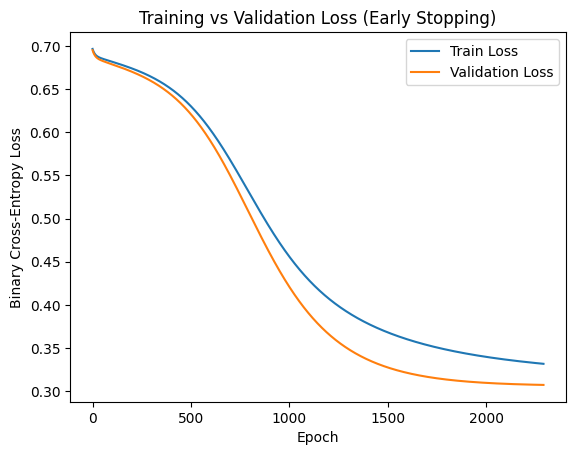

In [50]:
# Plt to show downward trend of loss function
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss (Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.show()


## Interpreting the Loss Curves

- **Training loss** should generally decrease over time.
- **Validation loss** should also decrease while the model is learning patterns that generalise.

Early stopping is triggered when validation loss stops improving for `patience` epochs.
At that point, training halts and the model is restored to the weights that produced the
lowest validation loss.


## Conclusion

This mini-project implemented a fully working neural network for heart disease prediction using only NumPy, following the lecture material on forward propagation, backpropagation, and gradient descent.

The dataset was manually preprocessed (binary encoding, one-hot encoding, and normalisation), then used to train a multi-layer network with a sigmoid output and binary cross-entropy loss. To reduce overfitting, a validation split and early stopping were introduced, stopping training automatically when validation loss no longer improved and restoring the best-performing weights.

Overall, the results demonstrate that the network learns meaningful patterns from the clinical features and that learning behaviour can be verified through the loss curves and test-set performance.
